# Machine learning engineer Nanodegree
## Project : Recognizing digits from real world images

In this project, we implement a convolutional neural network for image classification. The particular task is to recognize digits from the real world street view house number(SVHN) dataset.

In [1]:
#import all the required libraries
%matplotlib inline
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import h5py
import scipy

import os.path
import time
from six import iteritems
import itertools

## Read the input data from the SVHN dataset

The SVHN dataset is available here : http://ufldl.stanford.edu/housenumbers/ and the data comes in 2 formats namely 

**Format1** : contains full numbers (each number can have multiple digits) and this also comes along with a digitStruct.mat file that contains the boinding box information for each digit.

**Format2** : contains only individual digits that are cropped from the original image each image has been cropped via square windows by extending the original bounding boxes and the numbers are then resized to 32,32 dimension.

Since in this project we need both individual digit level accuracy and also full number accuracy, we will use format1 and crop the individual digits ourselves. For that purpose, I am reusing some of the code available at https://github.com/mila-udem/fuel/blob/master/fuel/converters/svhn.py (Fuel is a data pipeline framework for machine learning that provides machine learning models along with the data they need to learn)

Before running the project further, download the training and test data from the ufdl website and extract them to their corresponding folders and then update the below 2 lines by giving the folders where the data was extracted.

(Note that due to computational limitations, we are only using the training and testing data and we do not use the ~530k additional data that is available in the web site)

In [2]:
# modify these 2 lines by specifying the folder where the training and testing data was extracted.
train_folder = '/home/santhosh/svhn/data/form1/train'
test_folder = '/home/santhosh/svhn/data/form1/test'

#modify this variable to point to the folder where the checkpoint files will be created.
ckpt_file = '/home/santhosh/svhn/checkpoint/model.ckpt'

In [3]:
# the below functions are adapted from the fuel project described above
# ref :  https://github.com/mila-udem/fuel/blob/master/fuel/converters/svhn.py

# these are the named entities present in the digitStruct for each image using which
# we can retrieve the bounding box and the target label for each digit within each image
names = ('label', 'height', 'width', 'left', 'top')

def get_dataset(group, image_ref, name):
    return group[image_ref][name][:, 0]

# For each level, this function gets individual dataset 
# (this is just like a reference which can be used again to index into the 
# main group of the h5py format, i.e the digitStruct.bbox in our case)
def get_datasets(group, image_ref):    
    datasets = dict([(name, get_dataset(group, image_ref, name)) for name in names])
    return datasets

# For a particular number, if there are n digits, then we have to retrieve
# parts like height, width, left, top, label each as an individual array
# and each of length 'n' 
#
# The dataset parameter is like an array of references into the main group
# the references are nothing but references to each of the named entities like 
# label, height, width, left and top
#
# If there is only one bounding box, the information is
# stored directly in the datasets. If there are
# multiple bounding boxes, elements of those datasets
# are object references pointing to 1x1 datasets that
# store the information.
#
# This function returns the dimensions of each label. Note that the len of each 
# dimension is equal to the number of digits in that particular image
def get_elements(group, dataset):
    if len(dataset) > 1:
        return [int(group[ref][0, 0])
                for ref in dataset]
    else:
        return [int(dataset[0])]

In [4]:
# gets the i-th image (this will be a numpy array that we can then slice to get individual digits
# using the i-th row in the bbox from the digitStruct.mat file )
def get_img(folder, idx):
    image_file = os.path.join(folder, str(idx) + '.png')    
    img = mpimg.imread(image_file)
    return img

In [5]:
# this function will be called per image.
# Given the dimensions of the named_entities that was described above, this function
# returns the actual image of each digit within that image (as a numpy array scaled to 32x32)
def get_digs(dims, img):
    tot_dig = len(dims['labels'])
    digs = np.empty([tot_dig, 32, 32, 3])
    for i in range(tot_dig):
        dim1_beg = dims['tops'][i]
        dim1_end = dim1_beg + dims['heights'][i]
        dim2_beg = dims['lefts'][i]
        dim2_end = dim2_beg + dims['widths'][i]

        dig = img[dim1_beg:dim1_end, dim2_beg:dim2_end, :]
        if 0 in list(dig.shape):
            return None
        res_dig = scipy.misc.imresize(dig, [32,32,3])
        digs[i] = res_dig
    return digs

In [6]:
#get all the digits (i.e pixels for the individual digit) and the corresponding label and also
#the number to which each digit belongs to.
def get_digs_and_labels(folder_name):
    
    # the digitstruct.mat file contains details about the bounding boxes for the images
    # first access the main group and then index into bbox within that main group
    # this bbox contains as many rows as there are images in the folder.
    # main_group['bbox'][d,0] gives us a reference to the d-th image
    # using this reference, we get a list of all digits within the image (i.e the bounding boxes
    # and the corresponding labels)
    mat_file = os.path.join(folder_name, 'digitStruct.mat')
    f = h5py.File(mat_file,  'r')
    main_group = f['digitStruct']

    a = []
    num_idx = []
    labels = []
    
    num_read_error = 0
    
    for d in range(len(main_group['bbox'])):
        im_ref = main_group['bbox'][d, 0]
        datasets = get_datasets(main_group, im_ref)
        dims = dict([(name + 's', get_elements(main_group, dataset)) for 
                     name, dataset in iteritems(datasets)])
        img = get_img(folder_name, d+1)
        digs = get_digs(dims, img)
        if digs == None:
            num_read_error += 1
            print ('Empty index ', d)
        else:
            if d%100 == 0:
                print ('progress', d)
            #store number indexes, for example if the first number is 19, then we append 
            #[1,1] to the num_idx list denoting that the these 2 digits belong to number 1
            num_idx += [d+1] * digs.shape[0]

            #append the label for each digit
            for l in range(len(dims['labels'])):                
                labels.append(dims['labels'][l])

            #append each training digit to the array
            for dig in digs:        
                a.append(dig)

    all_digs = np.array(a)
    all_num_idxs = np.array(num_idx)
    all_labels = np.array(labels)

    print ('orig digits:', len(main_group['bbox']))
    print ('converted : numbers:%d, digits:%d' % (len(main_group['bbox'])-num_read_error, len(all_digs)))
    
    print ('all_digs', all_digs.shape)
    print ('all_num_idxs', all_num_idxs.shape)
    print ('all_labels', all_labels.shape)
    
    return all_num_idxs, all_digs, all_labels

In [7]:
# get the training indices, digits and labels
#
# the train_digs are the scaled 32x32 digits cropped from each image.
# 
# the train_labels denote the actual label for each of those digits
#
# the training indices denote which image each digit belongs to,for example if 
# train_digs[0] and train_digs[1] belong to the first image, then 
# train_num_idx[0] and train_num_idx[1] will be 1
train_num_idxs, train_digs, train_labels = get_digs_and_labels(train_folder)

/home/santhosh/tensorflow35/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


progress 0
progress 100
progress 200
Empty index  251
progress 300
progress 400
progress 500
progress 600
progress 700
Empty index  723
progress 800
progress 900
progress 1000
progress 1100
progress 1200
progress 1300
progress 1400
progress 1500
progress 1600
progress 1700
progress 1800
progress 1900
progress 2000
progress 2100
progress 2200
progress 2300
progress 2400
progress 2500
progress 2600
progress 2700
progress 2800
progress 2900
progress 3000
Empty index  3099
progress 3100
progress 3200
progress 3300
progress 3400
progress 3500
progress 3600
progress 3700
progress 3800
progress 3900
progress 4000
progress 4100
progress 4200
progress 4300
progress 4400
progress 4500
progress 4600
progress 4700
progress 4800
progress 4900
progress 5000
progress 5100
progress 5200
progress 5300
Empty index  5311
progress 5400
progress 5500
progress 5600
progress 5700
progress 5800
progress 5900
progress 6000
progress 6100
progress 6200
progress 6300
progress 6400
progress 6500
progress 6600
prog

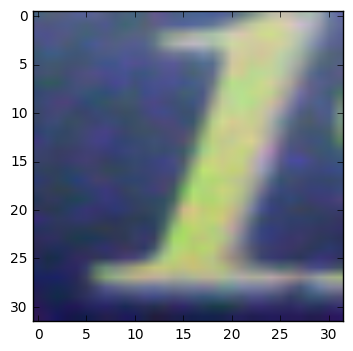

In [8]:
plt.imshow(train_digs[0])

In [9]:
# similarly get the test digits, labels and indexes
test_num_idxs, test_digs, test_labels = get_digs_and_labels(test_folder)

/home/santhosh/tensorflow35/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


progress 0
progress 100
progress 200
progress 300
Empty index  343
progress 400
Empty index  438
progress 500
Empty index  520
progress 600
progress 700
progress 800
progress 900
progress 1000
progress 1100
progress 1200
progress 1300
progress 1400
progress 1500
progress 1600
progress 1700
progress 1800
progress 1900
progress 2000
progress 2100
progress 2200
progress 2300
progress 2400
progress 2500
progress 2600
Empty index  2612
progress 2700
progress 2800
progress 2900
progress 3000
progress 3100
progress 3200
progress 3300
progress 3400
progress 3500
progress 3600
progress 3700
progress 3800
progress 3900
progress 4000
progress 4100
progress 4200
progress 4300
progress 4400
progress 4500
progress 4600
progress 4700
progress 4800
progress 4900
progress 5000
progress 5100
progress 5200
Empty index  5259
progress 5300
progress 5400
progress 5500
progress 5600
progress 5700
progress 5800
progress 5900
progress 6000
progress 6100
progress 6200
progress 6300
progress 6400
progress 6500
p

# Define the Convolutional neural network
The neural network model is adapted from the tensorflow implementation using convolutional neural networks for the MNIST dataset (ref: https://www.tensorflow.org/versions/r0.8/tutorials/mnist/pros/index.html)

We use a fairly similar model with 2 convolutional layers followed by a fully connected layer followed by a softmax layer which is used to read off the digits.

In [61]:
#helper functions
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)

# convolution layer with stride of 1
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# max pooling over 2x2 blocks
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# average pooling over 2x2 blocks
def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [62]:
# define the dimensions (with 8GB of RAM I could only test with a batch size of 500, 
# more than this and there was memory pressure on the system; possibly we could use
# a larger batch size with a higher RAM)
batch_size = 500

#first conv layer
W_conv1 = weight_variable([5, 5, 3, 20], 'w1')
b_conv1 = bias_variable([20], 'b1')

#2nd conv layer
W_conv2 = weight_variable([5, 5, 20, 50], 'w2')
b_conv2 = bias_variable([50], 'b2')

#fc layer
W_fc1 = weight_variable([8 * 8 * 50, 500], 'w3')
b_fc1 = bias_variable([500], 'b3')

#softmax
W_fc2 = weight_variable([500, 10], 'w4')
b_fc2 = bias_variable([10], 'b4')

In [63]:
# define x and y as placeholders for passing in input data (in batches of batch_size)
x = tf.placeholder(tf.float32, shape=(batch_size, 32, 32, 3), name = 'x')
y_ = tf.placeholder(tf.float32, shape=(batch_size, 10), name = 'y_')

Let’s denote Convolutional layer 1 and 2 as CONV1 and CONV2 respectively. will Both CONV1 and CONV2 use 5x5 filter. For CONV1, the input depth is 3 color channels (note that this is nothing but the number of color channels of the input data) and the output is 20 color channels. So the filter for CONV1 is [5, 5, 3, 20]. Similarly CONV2 which operates on the output of CONV1 has input depth as 20 and output depth as 50, so the filter for CONV2 is [5, 5, 20, 50]. For both the convolutional layers, we maintain a stride of 1 and have padding as SAME, so that the output size of the conv layer is the same as that of its input.

In each convolutional layer, after the convolution operation is applied, we also add the bias defined for that layer. So for CONV1, the dimension of the bias is [20] since there are 20 output channels for each input image. And similarly for CONV2, the dimension of the bias is [50].

At each convolutional layer, after adding the bias to the output of the convolution operation we do max pooling in a window of 2x2. So the output dimension of each convolution layer will be halved in the x and y dimensions. After applying max pooling we apply the ReLU non-linearity to get the output.

In [64]:
#connect the layers
h_conv1_out = conv2d(x, W_conv1) + b_conv1
h_maxpool1_out = avg_pool_2x2(h_conv1_out)
h_out1 = tf.nn.relu(h_maxpool1_out)

h_conv2_out = conv2d(h_out1, W_conv2) + b_conv2
h_maxpool2_out = avg_pool_2x2(h_conv2_out)
h_out2 = tf.nn.relu(h_maxpool2_out)

h_out2_shape = h_out2.get_shape().as_list()
h_out2_flat = tf.reshape(h_out2, [h_out2_shape[0], 8*8*50])
h_fc1 = tf.nn.relu(tf.matmul(h_out2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y_out = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
prediction = tf.argmax(y_out,1)

### Cost function
We use the softmax cross entropy with logits as the cost function.

What this does is to compute the cross entropy of the result after applying the softmax. Note that the logits are the unnormalized output of the network before softmax is applied on them. And the softmax function squashes an unnormalized vector of real values to the range (0,1) that add up to 1. 

Intuitively, the cross entropy function that tells us how different the prediction is from the actual value and a low value here indicates that we are doing well in classifying the correct digit

In [65]:
#define the training step and cross entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_out, y_))
train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)
cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(y_out, y_))

actual_y = tf.argmax(y_,1)
correct_prediction = tf.equal(tf.argmax(y_out,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Split the data into training, validation and test sets
We split the original training data which has around 73k individual digits into a training set of 53k digits and a validation set of 20k images (this is the hold out cross validation technique) and on every epoch we just shuffle the training data so that we dont present the images that are highly corelated to each mini-batch.

As for the test set, we just use the entire test set of 26k images that we originally obtained.

We convert the y labels from a number in the range 1-10 to a one hot encoded array. For each digit, we have a 10 dimensional one-hot encoded array. If this actual digit is 'd', then the d-th element of this array will be set to 1 and all other elements will be set to 0. Note that the digit 0 is represented by the number 10. So for the digit 0, the 10th element of the one-hot encoded array will be set to 1.

In [66]:
#train, validation and test sets
x_tr_val = train_digs
x_test = test_digs
y_tr_val = pd.get_dummies(train_labels.ravel()).as_matrix()
y_test = pd.get_dummies(test_labels.ravel()).as_matrix()

#rounding off to nearest multiple of 1000 for ease of maintaining state
train_size = 53000
validation_size = 20000
test_size = 26000

In [67]:
#train, validation and test sets
x_tr_val = train_digs
x_test = test_digs
y_tr_val = pd.get_dummies(train_labels.ravel()).as_matrix()
y_test = pd.get_dummies(test_labels.ravel()).as_matrix()

#rounding off to nearest multiple of 1000 for ease of maintaining loop state while training
train_size = 53000
validation_size = 20000
test_size = 26000

x_tr_val = x_tr_val[:train_size+validation_size]
y_tr_val = y_tr_val[:train_size+validation_size]
tr_idxs = train_num_idxs[:train_size+validation_size]

x_test = x_test[:test_size]
y_test = y_test[:test_size]
test_idxs = test_num_idxs[:test_size]

x_tr_val, y_tr_val, tr_idxs = sklearn.utils.shuffle(x_tr_val, y_tr_val, tr_idxs)
x_test, y_test, test_num_idxs = sklearn.utils.shuffle(x_test, y_test, test_idxs)

x_train = x_tr_val[:train_size]
y_train = y_tr_val[:train_size]
train_idxs = tr_idxs[:train_size]

x_validation = x_tr_val[train_size:train_size+validation_size]
y_validation = y_tr_val[train_size:train_size+validation_size]
val_idxs = tr_idxs[train_size:train_size+validation_size]

### visualize the class labels
Note that if the label is marked as 10, then it actually the digit 0.

We just plot a histogram of the different classes to see if there is any class imbalance and as we can see below, the 1's, 2's and 3's are much larger in number compared to 8's, 9's, and 0's. So this would mean that we can use F1 score as a way of evaluating the model (in addition to the prediction accuracy)

(array([ 13847.,  10577.,   8488.,   7456.,   6877.,   5724.,   5587.,
          5040.,   4657.,   4944.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

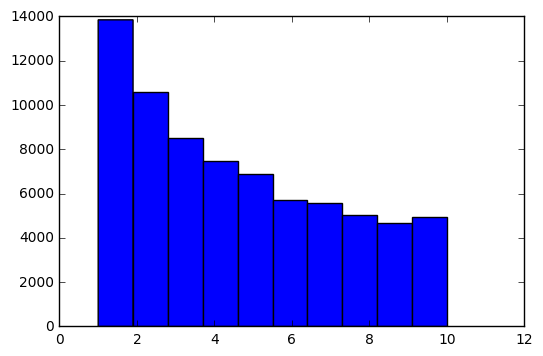

In [68]:
plt.hist(train_labels)

In [69]:
# just a sanity check of the shape of the training and validation set before proceding
print(x_train.shape, y_train.shape, train_idxs.shape)
print (x_validation.shape, y_validation.shape,val_idxs.shape)
print (x_test.shape, y_test.shape, test_idxs.shape)

(53000, 32, 32, 3) (53000, 10) (53000,)
(20000, 32, 32, 3) (20000, 10) (20000,)
(26000, 32, 32, 3) (26000, 10) (26000,)


### The training process
First we define some helper functions that will be used for comparing the predicted y values with the taget y values.

In [70]:
#gets the actual digit y corresponding to the one hot encoded y
def get_y_act(y):
    y_act = np.empty(len(y))
    for i in range(int(len(y)/batch_size)):
        start = i*batch_size
        end = start + batch_size
        y_act1 = session.run(actual_y, feed_dict = {y_:y[start:end]}) 
        y_act[start:end] = y_act1
    return y_act

In [71]:
# With the state of the current model, this function evaluates the accuracy 
# of predicting the digits denoted by _x whose target is _y
def accuracy_eval(_x, _y):
    pred = np.empty([len(_y)])
    tot_cost = 0
    for i in range (int(len(_y)/batch_size)):
        start = i*batch_size
        end = start + batch_size
        p = session.run(prediction, feed_dict={x:_x[start:end], keep_prob:1.0})
        c = session.run(cost, feed_dict={x:_x[start:end], y_:_y[start:end], keep_prob:1.0})
        tot_cost += c
        pred[start:end] = p
    y_act = get_y_act(_y)

    acc = np.mean(pred == y_act)
    return float(tot_cost), acc

def test_accuracy_eval():
    return accuracy_eval(x_test, y_test)

def validation_accuracy_eval(num_elem):
    return accuracy_eval(x_validation[:num_elem], y_validation[:num_elem])

def train_accuracy_eval(num_elem):
    return accuracy_eval(x_train[:num_elem], y_train[:num_elem])

In [72]:
# gets the predicted y value for the entire test data
def get_y_pred():
    pred = np.empty([len(y_test)])
    tot_cost = 0
    for i in range (int(len(y_test)/batch_size)):
        start = i*batch_size
        end = start + batch_size
        p = session.run(prediction, feed_dict={x:x_test[start:end], keep_prob:1.0})
        pred[start:end] = p
    return pred

We also periodically save the state of our model into a checkpoint file (so this will be useful for later retrieval if we choose to restart the training process for some reason but maintaining the same set of parameters)

We also maintain an accumulated array of training and validation cost and accuracy so this can be used for plotting the validation curves later.

In [73]:
global_epoch = 0
saver = tf.train.Saver({
        "var_w1": W_conv1,
        "var_b1": b_conv1,
        "var_w2": W_conv2,
        "var_b2": b_conv2,
        "var_w3": W_fc1,
        "var_b3": b_fc1,
        "var_w4": W_fc2,
        "var_b4": b_fc2,
    })
train_cost = []
val_cost = []
train_acc = []
val_acc = []

In [74]:
# given a history of past scores (the scores are typically validation costs), 
# this function returns if the scores have flattened out (i.e they
# do not show much improvement over the past 10 runs)
# if the percentage improvement is less than 0.5%, then 
def scores_flattened(scores):
    is_flattened = False
    if len(scores) > 10:
        print ('curr_score={}, prev_score={}'.format(scores[len(scores)-1], scores[len(scores)-11]))
        if scores[len(scores)-11] != 0:
            cost_improvement = (scores[len(scores)-11] - scores[len(scores)-1]) / (scores[len(scores)-11])
            is_flattened = cost_improvement < 0.005
            print ('scores_flattened_check : cost_improvement=', cost_improvement)
    return is_flattened

In [75]:
# the actual training function which runs multiple epochs
# and within each epoch, training using batch_size number of examples in a single run of the training set
# finally at the end of each epoch, calculate the cost function and the acuracy 
# for both training and valdation set.
def train(num_epochs):    
    #drop out
    #initially we have no dropout, but after the validation curves flattens out, we introduce some
    #dropout so as to avoid overfitting
    drop = 0.0
    for epoch in range(num_epochs):        
        global ckpt_file
        global batch_size
        global global_epoch
        global saver
        global x_train, y_train, train_idxs
        global x_validation, y_validation, val_idxs
        global train_cost, val_cost, train_acc, val_acc
        
        if shuffle_on_each_run:
            #before each epochs, we reshuffle the data so that we dont get fixated on the same set
            #of training and validation data for each epoch
            x_train, y_train, train_idxs = sklearn.utils.shuffle(x_train, y_train, train_idxs)
        
        global_epoch += 1
        start_time = time.time()
        
        tot_iter = int(len(y_train)/batch_size)
        start = 0
        for i in range(tot_iter):
        #for i in range(2): #just for testing
            session.run(train_step, feed_dict={
                    x: x_train[start:start+batch_size], 
                    y_: y_train[start:start+batch_size],
                    keep_prob: 1.0-drop})
            start += batch_size

        #save the variable state to a checkpoint file, so that this data can be retrieved later
        #if process crashes in the middle for some reason, then we do not loose our work
        save_path = saver.save(session, ckpt_file)
        #to restore the variables within a session make the following call
        #saver.restore(session, "/home/santhosh/svhn/checkpoint/model.ckpt")
        
        t_cost, t_acc = train_accuracy_eval(20000)
        train_cost.append(t_cost)
        train_acc.append(t_acc)
        
        # to save on training time, we only evaluate the training cost on a subset of the training data
        # (i.e 20k images instead of the entire dataset of 53k images)
        v_cost, v_acc = validation_accuracy_eval(20000)        
        val_cost.append(v_cost)
        val_acc.append(v_acc)
        
        #check if validation score has flattened, and if so, increase the dropout by 10% until we reach 50% dropout
        if epoch%10 == 0 and scores_flattened(val_cost):
            drop = min(0.5, drop+0.1)
            print ("dropout, new value : ", drop)
        
        end_time = time.time()
        
        print("epoch [global=%d] curr=%d/%d train_cost:%.1f, train_acc:%.3f, val_cost:%.1f, val_acc:%.3f, time:%d" % 
              (global_epoch, epoch+1, num_epochs, t_cost, t_acc, v_cost, v_acc, end_time-start_time)) 

In [76]:
# create a session and initialize the variables
session = tf.Session()
session.run(tf.initialize_all_variables())

In [77]:
#restore the previously stored variables
saver.restore(session, ckpt_file)

In [60]:
session.close()

In [79]:
# the main script that trains n epochs
import time
start = time.time()

batch_size = 500
shuffle_on_each_run = True

num_epochs = 20
train(num_epochs)
end = time.time()
print ('total time taken : ', end-start)

epoch [global=1] curr=1/20 train_cost:10562.6, train_acc:0.873, val_cost:12368.7, val_acc:0.861, time:114
epoch [global=2] curr=2/20 train_cost:7837.4, train_acc:0.890, val_cost:10551.2, val_acc:0.865, time:114
epoch [global=3] curr=3/20 train_cost:6237.8, train_acc:0.910, val_cost:9753.5, val_acc:0.871, time:114
epoch [global=4] curr=4/20 train_cost:5222.1, train_acc:0.923, val_cost:9497.2, val_acc:0.876, time:115
epoch [global=5] curr=5/20 train_cost:4735.0, train_acc:0.933, val_cost:9326.1, val_acc:0.881, time:114
epoch [global=6] curr=6/20 train_cost:3877.8, train_acc:0.945, val_cost:9296.4, val_acc:0.881, time:114
epoch [global=7] curr=7/20 train_cost:3348.3, train_acc:0.954, val_cost:9273.8, val_acc:0.884, time:114
epoch [global=8] curr=8/20 train_cost:2852.4, train_acc:0.962, val_cost:9233.5, val_acc:0.884, time:114
epoch [global=9] curr=9/20 train_cost:2292.4, train_acc:0.970, val_cost:9331.5, val_acc:0.885, time:114
epoch [global=10] curr=10/20 train_cost:1935.4, train_acc:0.9

### Interpreting the results
Now we will plot the error and accuracy from the training and validation sets.

In [81]:
# just sanity checking the acculated results
len(train_acc), len(val_acc), len(train_cost), len(val_cost)

(20, 20, 20, 20)

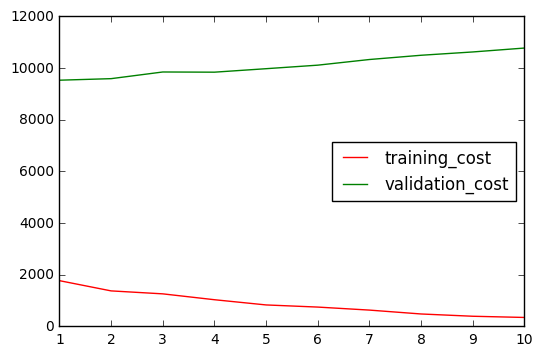

In [82]:
# plot the training and validation costs
# there are some initial fluctuations in the first few epochs, so we only plot from the 10th ecpoch 
# onwards when the weights have started to stabilize
plt.plot(list(range(1,len(train_cost[10:])+1)), train_cost[10:], color='red', label='training_cost')
plt.plot(list(range(1,len(val_cost[10:])+1)), val_cost[10:], color='green', label='validation_cost')
plt.legend(loc='best')
plt.show()

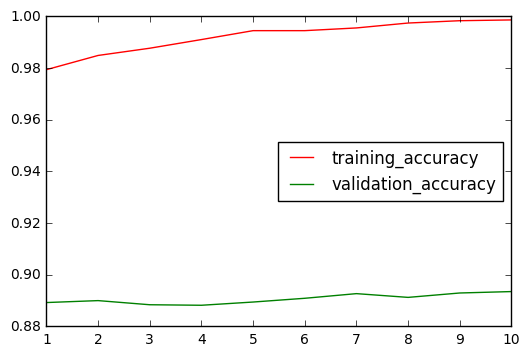

In [83]:
# plot the training and validation accuracy
plt.plot(list(range(1,len(train_acc[10:])+1)), train_acc[10:], color='red', label='training_accuracy')
plt.plot(list(range(1,len(val_acc[10:])+1)), val_acc[10:], color='green', label='validation_accuracy')
plt.legend(loc='best')
plt.show()

In [84]:
test_cost, test_acc = test_accuracy_eval()
print ('test_cost:%d test_acc:%.2f' % (test_cost, test_acc))

test_cost:32314 test_acc:0.82


In [85]:
# In the test set, compare the predicted y value with the target y value and get the f1_score
y_pred = get_y_pred()
y_act = get_y_act(y_test)
f1 = f1_score(y_act, y_pred, average='weighted')
print (f1)

0.824457095288


In [86]:
#print individual digit level accuracy and also full number level accuracy
tot_digs = len(y_act)
tot_correct_digs = sum(y_act == y_pred)
print ('total_digs:%d correct_preds:%d pred_accuracy:%.2f' % (tot_digs, tot_correct_digs, tot_correct_digs/tot_digs))

total_nums = max(test_num_idxs)
tot_correct_nums = 0
for num in range(1, total_nums+1):
    idxs = [i for i,n in enumerate(test_num_idxs) if n==num]
    num_act = y_act[idxs]
    num_pred = y_pred[idxs]
    if sum(num_act == num_pred) == len(idxs):
        tot_correct_nums += 1

print ('total_nums:%d correct_preds:%d pred_accuracy:%.2f' %(total_nums, tot_correct_nums, tot_correct_nums/total_nums))

total_digs:26000 correct_preds:21438 pred_accuracy:0.82
total_nums:13061 correct_preds:8954 pred_accuracy:0.69


In [81]:
#function to plot a confusion matrix - 
#taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          norm=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(title, figsize=(8,8))
    
    #extent=(-20, 20, -20, 20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if norm:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


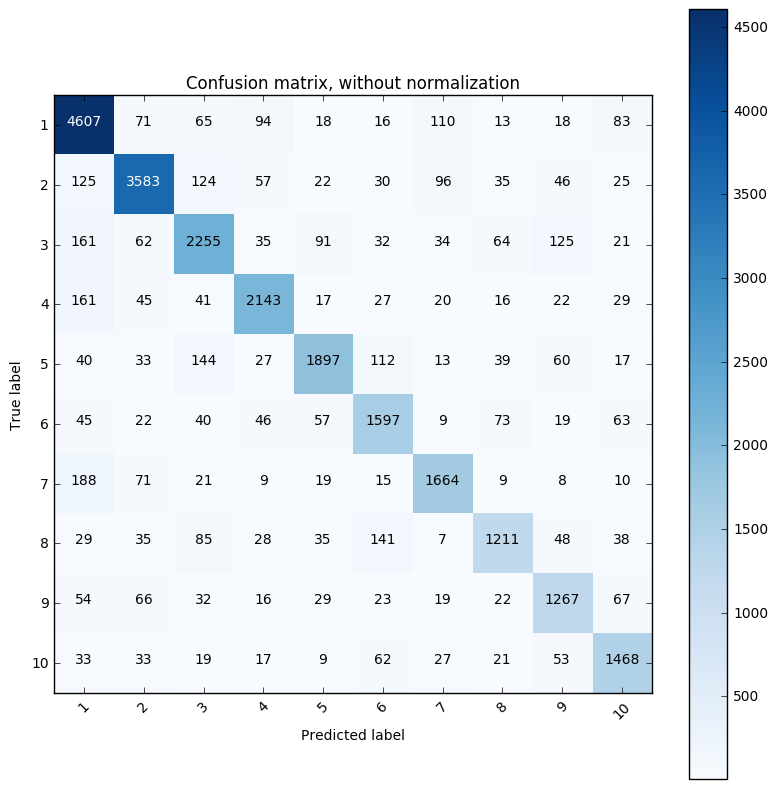

In [84]:
cnf_matrix = confusion_matrix(y_act, y_pred)
class_names = [x for x in range(1,11)]
plt.figure()
plot_confusion_matrix(cnf_matrix, class_names, title="Confusion matrix, without normalization")

Normalized confusion matrix


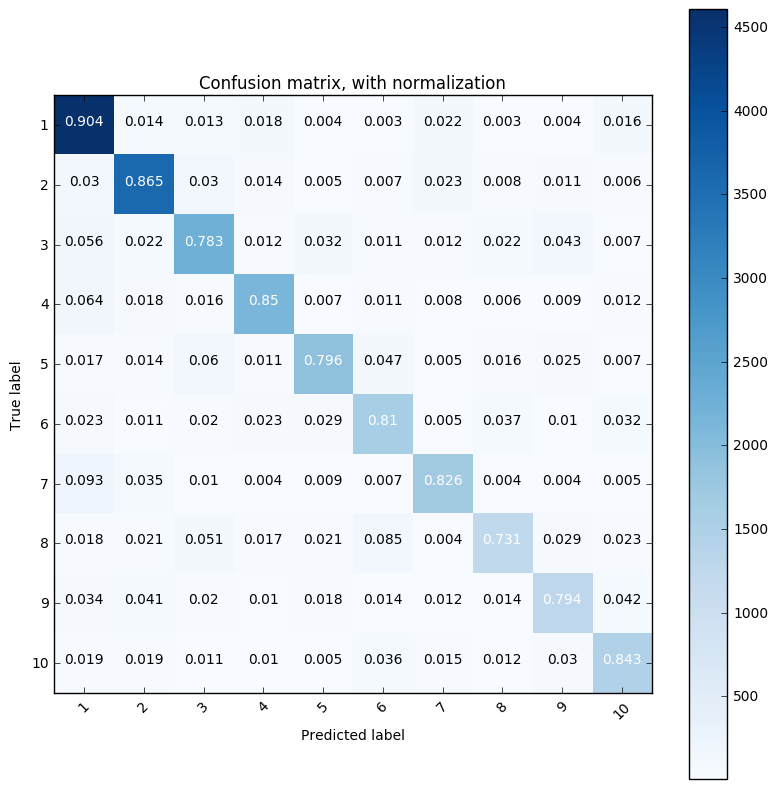

In [85]:
plt.figure()
plot_confusion_matrix(cnf_matrix, class_names, norm=True, title="Confusion matrix, with normalization")

In [86]:
session.close()